In [3]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from scalecast.Forecaster import Forecaster
from scalecast.AnomalyDetector import AnomalyDetector
from scalecast.SeriesTransformer import SeriesTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM
from keras.optimizers import Adam

In [7]:
data = pd.read_csv('BrentOilPrices.csv')
print('Informasi data : \n',data.info())
print('Jumlah Data kosong: \n',data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9011 entries, 0 to 9010
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    9011 non-null   object 
 1   Price   9011 non-null   float64
dtypes: float64(1), object(1)
memory usage: 140.9+ KB
Informasi data : 
 None
Jumlah Data kosong: 
 Date     0
Price    0
dtype: int64


In [8]:
data.head() # data yang dimiliki adalah data harian (dimulai dari hari kerja senin - jumat)

,Date,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63


### Anomaly Detection

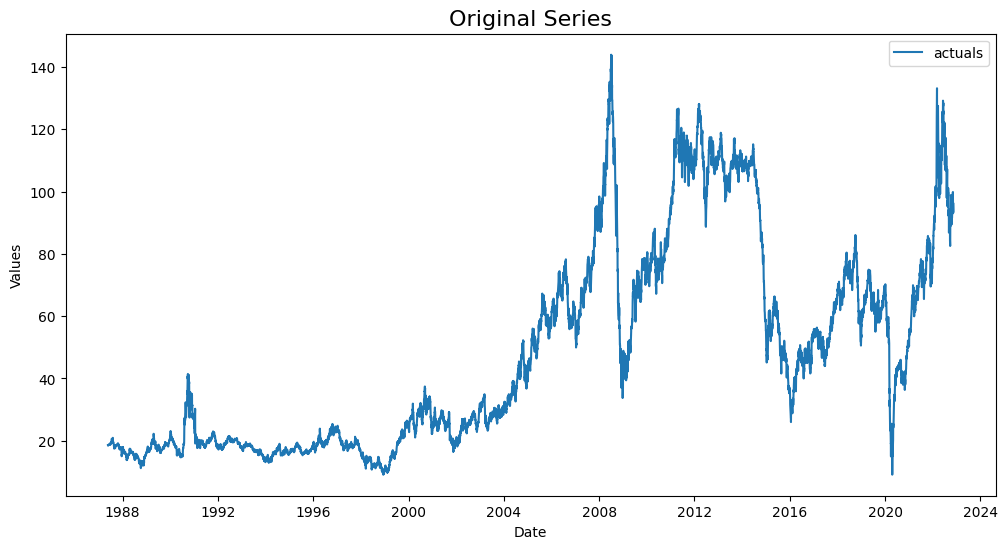

In [9]:
f = Forecaster(
    y=data['Price'],
    current_dates= data['Date']
)
f.plot()
plt.title('Original Series',size=16)
plt.show()

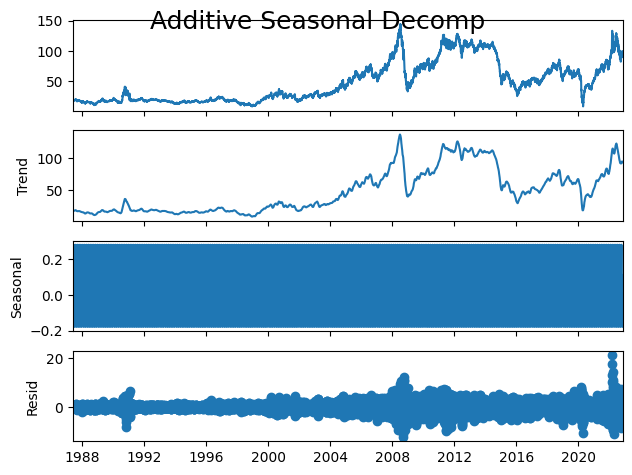

In [10]:
detector1 = AnomalyDetector(f)
f.seasonal_decompose(extrapolate_trend='freq', period =30).plot()
plt.suptitle('Additive Seasonal Decomp', size=18)
plt.show()

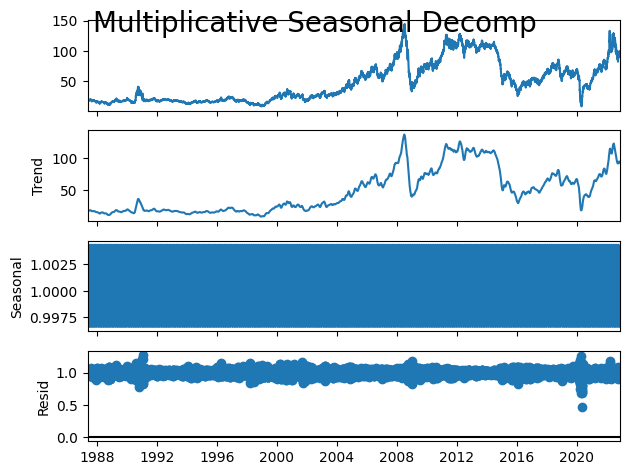

In [11]:
f.seasonal_decompose(
    model='multiplicative',
    period = 30,
    extrapolate_trend='freq'
).plot()
plt.suptitle('Multiplicative Seasonal Decomp',size=20)
plt.show()

In [12]:
detector1.EstimatorDetect(
    estimator='lstm',
    future_dates=30, # how many forecast steps to train into the lstm? default is 1
    cilevel=.99,
    lags=29,
    epochs=10,
    lstm_layer_sizes=(50,40,30),
    dropout=(0,0,0),
    verbose=0,
)


280/280 [==============================] - 4s 15ms/step


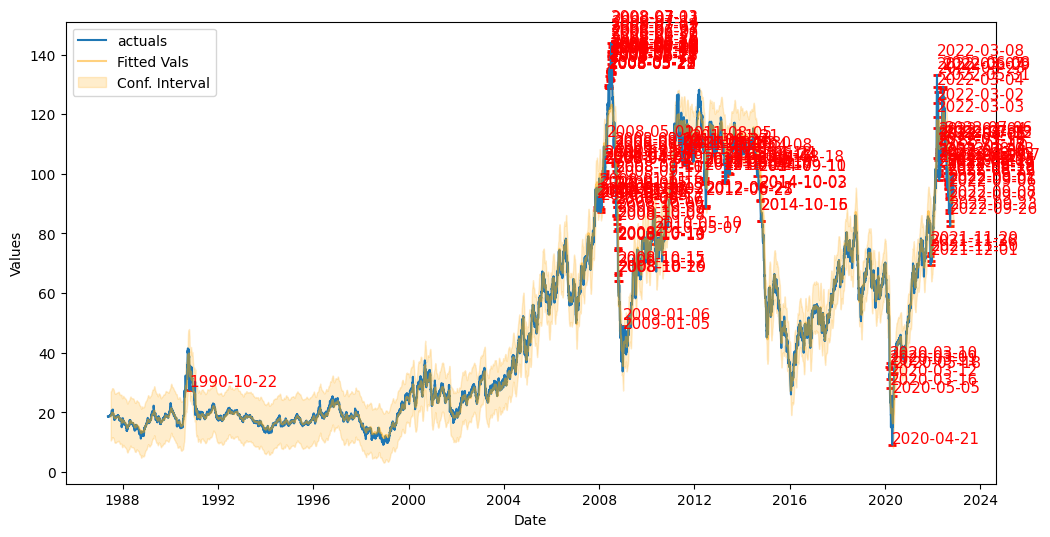

In [13]:
detector1.plot_anom()
plt.show()

In [14]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9011 entries, 1987-05-20 to 2022-11-14
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   9011 non-null   float64
dtypes: float64(1)
memory usage: 140.8 KB


In [16]:
montly_data = data.resample('M').mean()
montly_data.head()

,Price
Date,
1987-05-31,18.580000
1987-06-30,18.860476
1987-07-31,19.856522
1987-08-31,18.979524
1987-09-30,18.313182


Text(0.5, 1.0, 'Data Montly Price')

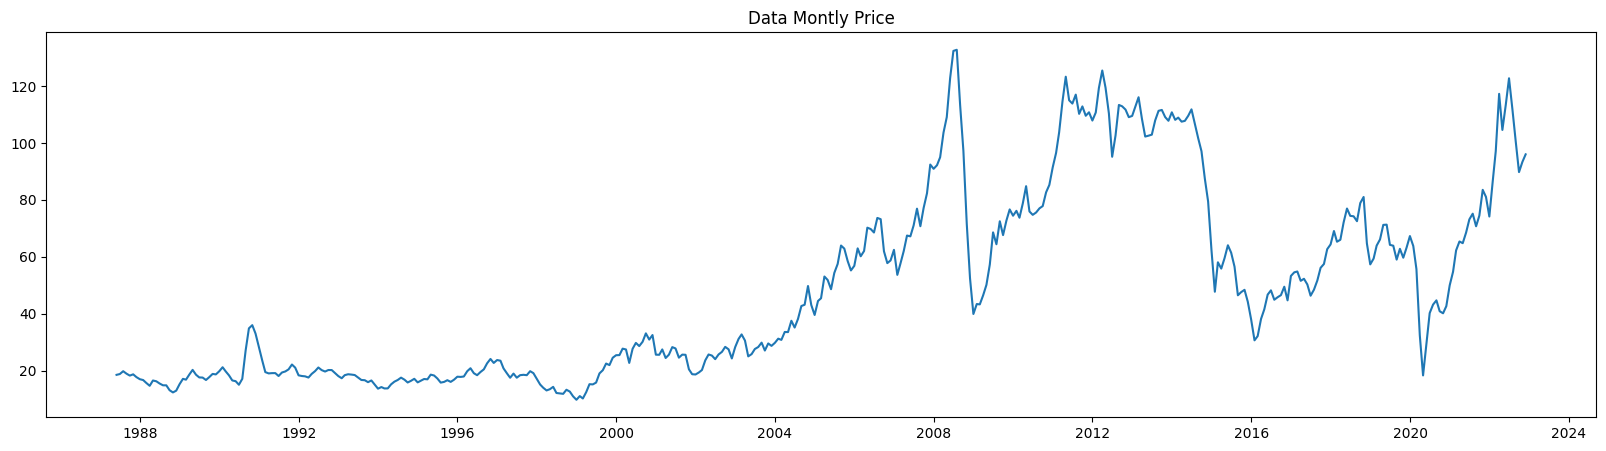

In [17]:
plt.figure(figsize=(20,5))
plt.plot(montly_data)
plt.title('Data Montly Price')

Check For Stationery

In [18]:
from statsmodels.tsa.stattools import adfuller
def ad_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print('1. ADF : ',dftest[0])
  print('2. P-Value : ',dftest[1])
  print('3. Num of Lags : ',dftest[2])
  print('4. Num of Observations User for ADF Regression and Critical Value Calculation : ',dftest[3])
  print('5. Critical Values : ')
  for key , val in dftest[4].items():
    print('\t', key, " : ", val)


def calculate_mae(actual, predicted):
  return np.mean(np.abs(actual-predicted))

def calculate_mape(actual, predicted):
  return 100*np.mean(np.abs((actual - predicted)/ actual))

def calculate_mad(data):
  return np.mean(np.abs(data - np.mean(data)))

In [19]:
ad_test(data['Price'])

1. ADF :  -1.9938560113924675
2. P-Value :  0.28927350489340287
3. Num of Lags :  29
4. Num of Observations User for ADF Regression and Critical Value Calculation :  8981
5. Critical Values : 
	 1%  :  -3.4310783342658615
	 5%  :  -2.861861876398633
	 10%  :  -2.566941329781918


Nilai ADF lebih positif dibandingkan nilai Critical Values, p-value berada diatas standar p-value senilai 0.05, oleh karena itu data tidak menolak hipotesis yang berarti bersifat non-stationer.

### Normalisasi

In [22]:
# melakukan Normalisasi
scale = StandardScaler()
data['Price'] = scale.fit_transform(data['Price'].values.reshape(-1,1))

In [ ]:
data

,Price
Date,
1987-05-20,-0.906644
1987-05-21,-0.912122
1987-05-22,-0.909079
1987-05-25,-0.907557
1987-05-26,-0.906644
...,...
2022-11-08,1.473881
2022-11-09,1.358233
2022-11-10,1.394754


In [20]:
def create_lstm_dataset(data, time_steps):
  df_as_np = data.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np) - time_steps):
    row = [[a] for a in df_as_np[i:i+5]]
    X.append(row)
    label = df_as_np[i+5]
    y.append(label)
  return np.array(X), np.array(y)

In [21]:
time_steps = 5
X, y = create_lstm_dataset(data, time_steps)
X.shape , y.shape

((9006, 5, 1, 1), (9006, 1))

<Axes: xlabel='Date'>

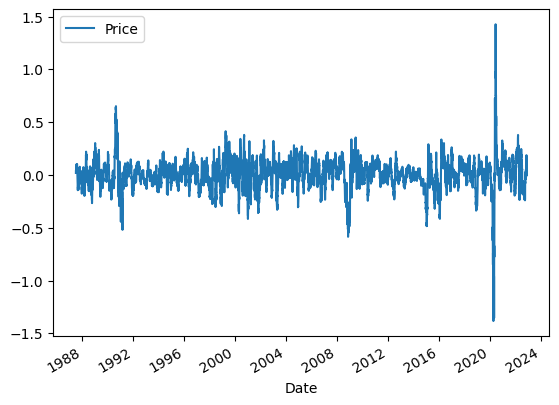

In [ ]:
data = np.log(data)
data_diff = data.diff(periods = 29).dropna()
data_diff.plot()

In [ ]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

In [ ]:
model_fit = auto_arima(data_diff['Price'], trace = True,
                       suppress_warnings=True)
model_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-34520.012, Time=9.75 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-9592.862, Time=0.48 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-34522.063, Time=0.33 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-18990.127, Time=3.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-9582.751, Time=0.40 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-34521.879, Time=1.69 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-34521.863, Time=0.71 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-34520.672, Time=2.26 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-34523.864, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-34523.675, Time=0.44 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-34523.659, Time=0.90 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-18981.868, Time=0.72 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-34522.456, Time=1.14 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 22.101 secon

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 8982
Model:               SARIMAX(1, 0, 0)   Log Likelihood               17263.932
Date:                Thu, 07 Dec 2023   AIC                         -34523.864
Time:                        14:15:06   BIC                         -34509.658
Sample:                             0   HQIC                        -34519.030
                               - 8982                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9684      0.001   1036.338      0.000       0.967       0.970
sigma2         0.0013   5.08e-06    246.750      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   1.70   Jarque-Bera (JB):            254563.88
Prob(Q):                              0.19   Prob(JB):                         0.00
Heteroskedasticity (H):               1.49   Skew:                             0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
train_data = data_diff.iloc[:-1803]
test_data = data_diff.iloc[-1803:]
print(train_data.shape ,test_data.shape )

(7179, 1) (1803, 1)


In [ ]:
model_train = arima(data_diff)